In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import miscMCMC.samplers.jax_ptmcmc as ptmcmc
from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# make PTA and likelihood objects
pta = PTA(Np=5,
          Tspan_yr=15.,
          Nf=5,
          model_wn=True,
          model_rn=True,
          model_gwb=True,
          model_cw=True,
          seed=1)
l = get_likelihood_obj(pta)

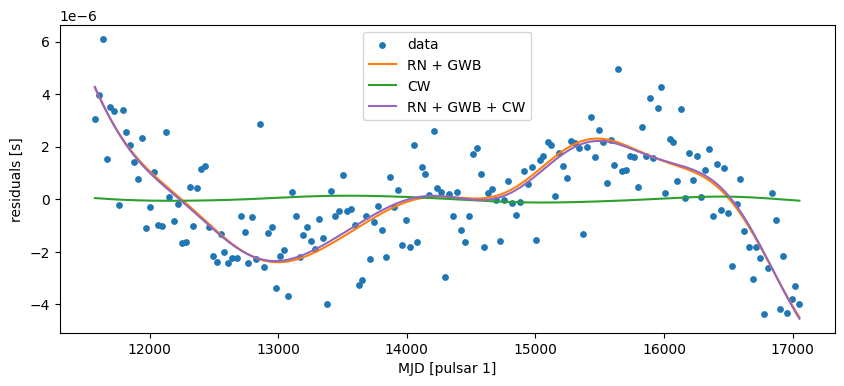

In [3]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
if pta.model_gwb or pta.model_rn:
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if pta.model_cw:
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (pta.model_gwb or pta.model_rn) and pta.model_cw:
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [5]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[pta.efac_ndxs]
    rn_hypers = x[pta.rn_ndxs]
    gwb_hypers = x[pta.gwb_ndxs]
    cw_psr_params = x[pta.cw_psr_ndxs]
    psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    # lnprior_val += l.a_lnprior_rn(rn_hypers, a)
    lnprior_val += l.a_lnprior_rn_gwb(rn_hypers, gwb_hypers, a)
    lnprior_val += l.psr_dist_lnprior(psr_dists)

    # likelihood
    a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(efacs, a + a_cw)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

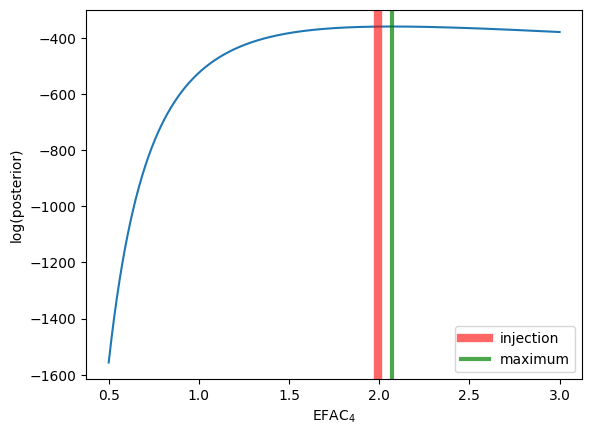

In [6]:
# plot cross-section of posterior
param_ndx = 3
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [7]:
@jit
def pt_lnpost(x, temperature=1.):
    return lnpost(x) / temperature

In [8]:
num_samples = int(1e6)
num_chains = 20
states, lnposts, temperature_ladder = ptmcmc.ptmcmc_sampler(num_samples=num_samples,
                                                            num_chains=num_chains,
                                                            logpdf_func=pt_lnpost,
                                                            x0=pta.x_inj,
                                                            x_mins=pta.x_mins,
                                                            x_maxs=pta.x_maxs,
                                                            temperature_ladder=1.2**jnp.arange(num_chains),
                                                            Fisher_jump_weight=20.,
                                                            DE_jump_weight=0.,
                                                            PT_swap_weight=20.,
                                                            Fisher_update_rate=0.05,
                                                            DE_history_with_Fisher=False,
                                                            seed=21)

jump acceptance rates

Fisher: [0.51600003 0.545      0.57000005 0.592      0.611      0.63000005
 0.648      0.66300005 0.67700005 0.69100004 0.702      0.71400005
 0.726      0.73800004 0.749      0.757      0.76600003 0.77300006
 0.786      0.799     ]

DE: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]

PT swap: [0.35500002 0.372      0.35900003 0.35000002 0.39400002 0.41300002
 0.409      0.44200003 0.42800003 0.43500003 0.448      0.44700003
 0.42100003 0.47900003 0.504      0.47000003 0.49400002 0.49500003
 0.528             nan]



In [14]:
# make samples object for post-processing
samples = Samples(samples_arr=states[:, 0],
                  labels=pta.x_labels,
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

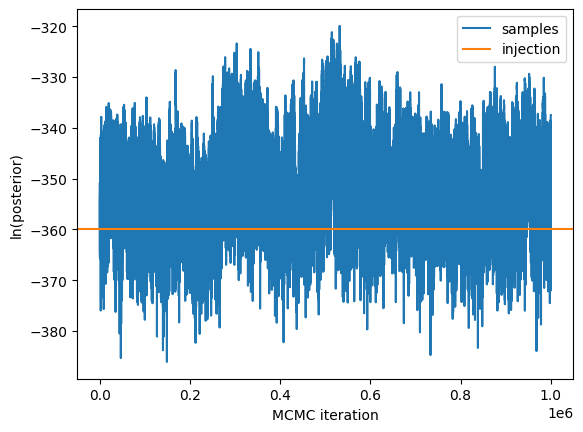

In [15]:
samples.plt_posterior_vals(legend=True)

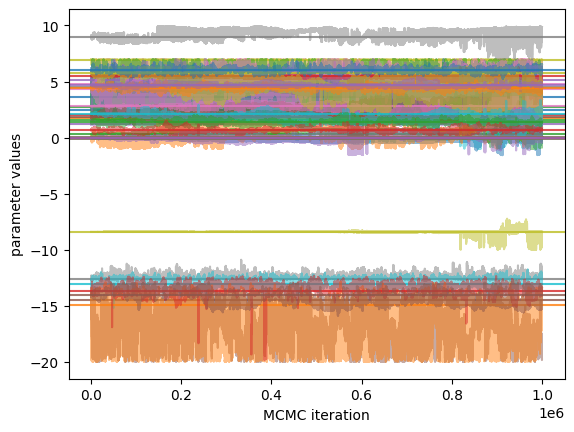

In [16]:
samples.trace_plt()

In [15]:
samples.plt_auto_corr()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20000;
tau: [29695.42936668]

Parameter $\gamma_{1}$ in chain samples is not constrained
Parameter $\log_{10}\,A_{4}$ in chain samples is not constrained
Parameter $\gamma_{4}$ in chain samples is not constrained


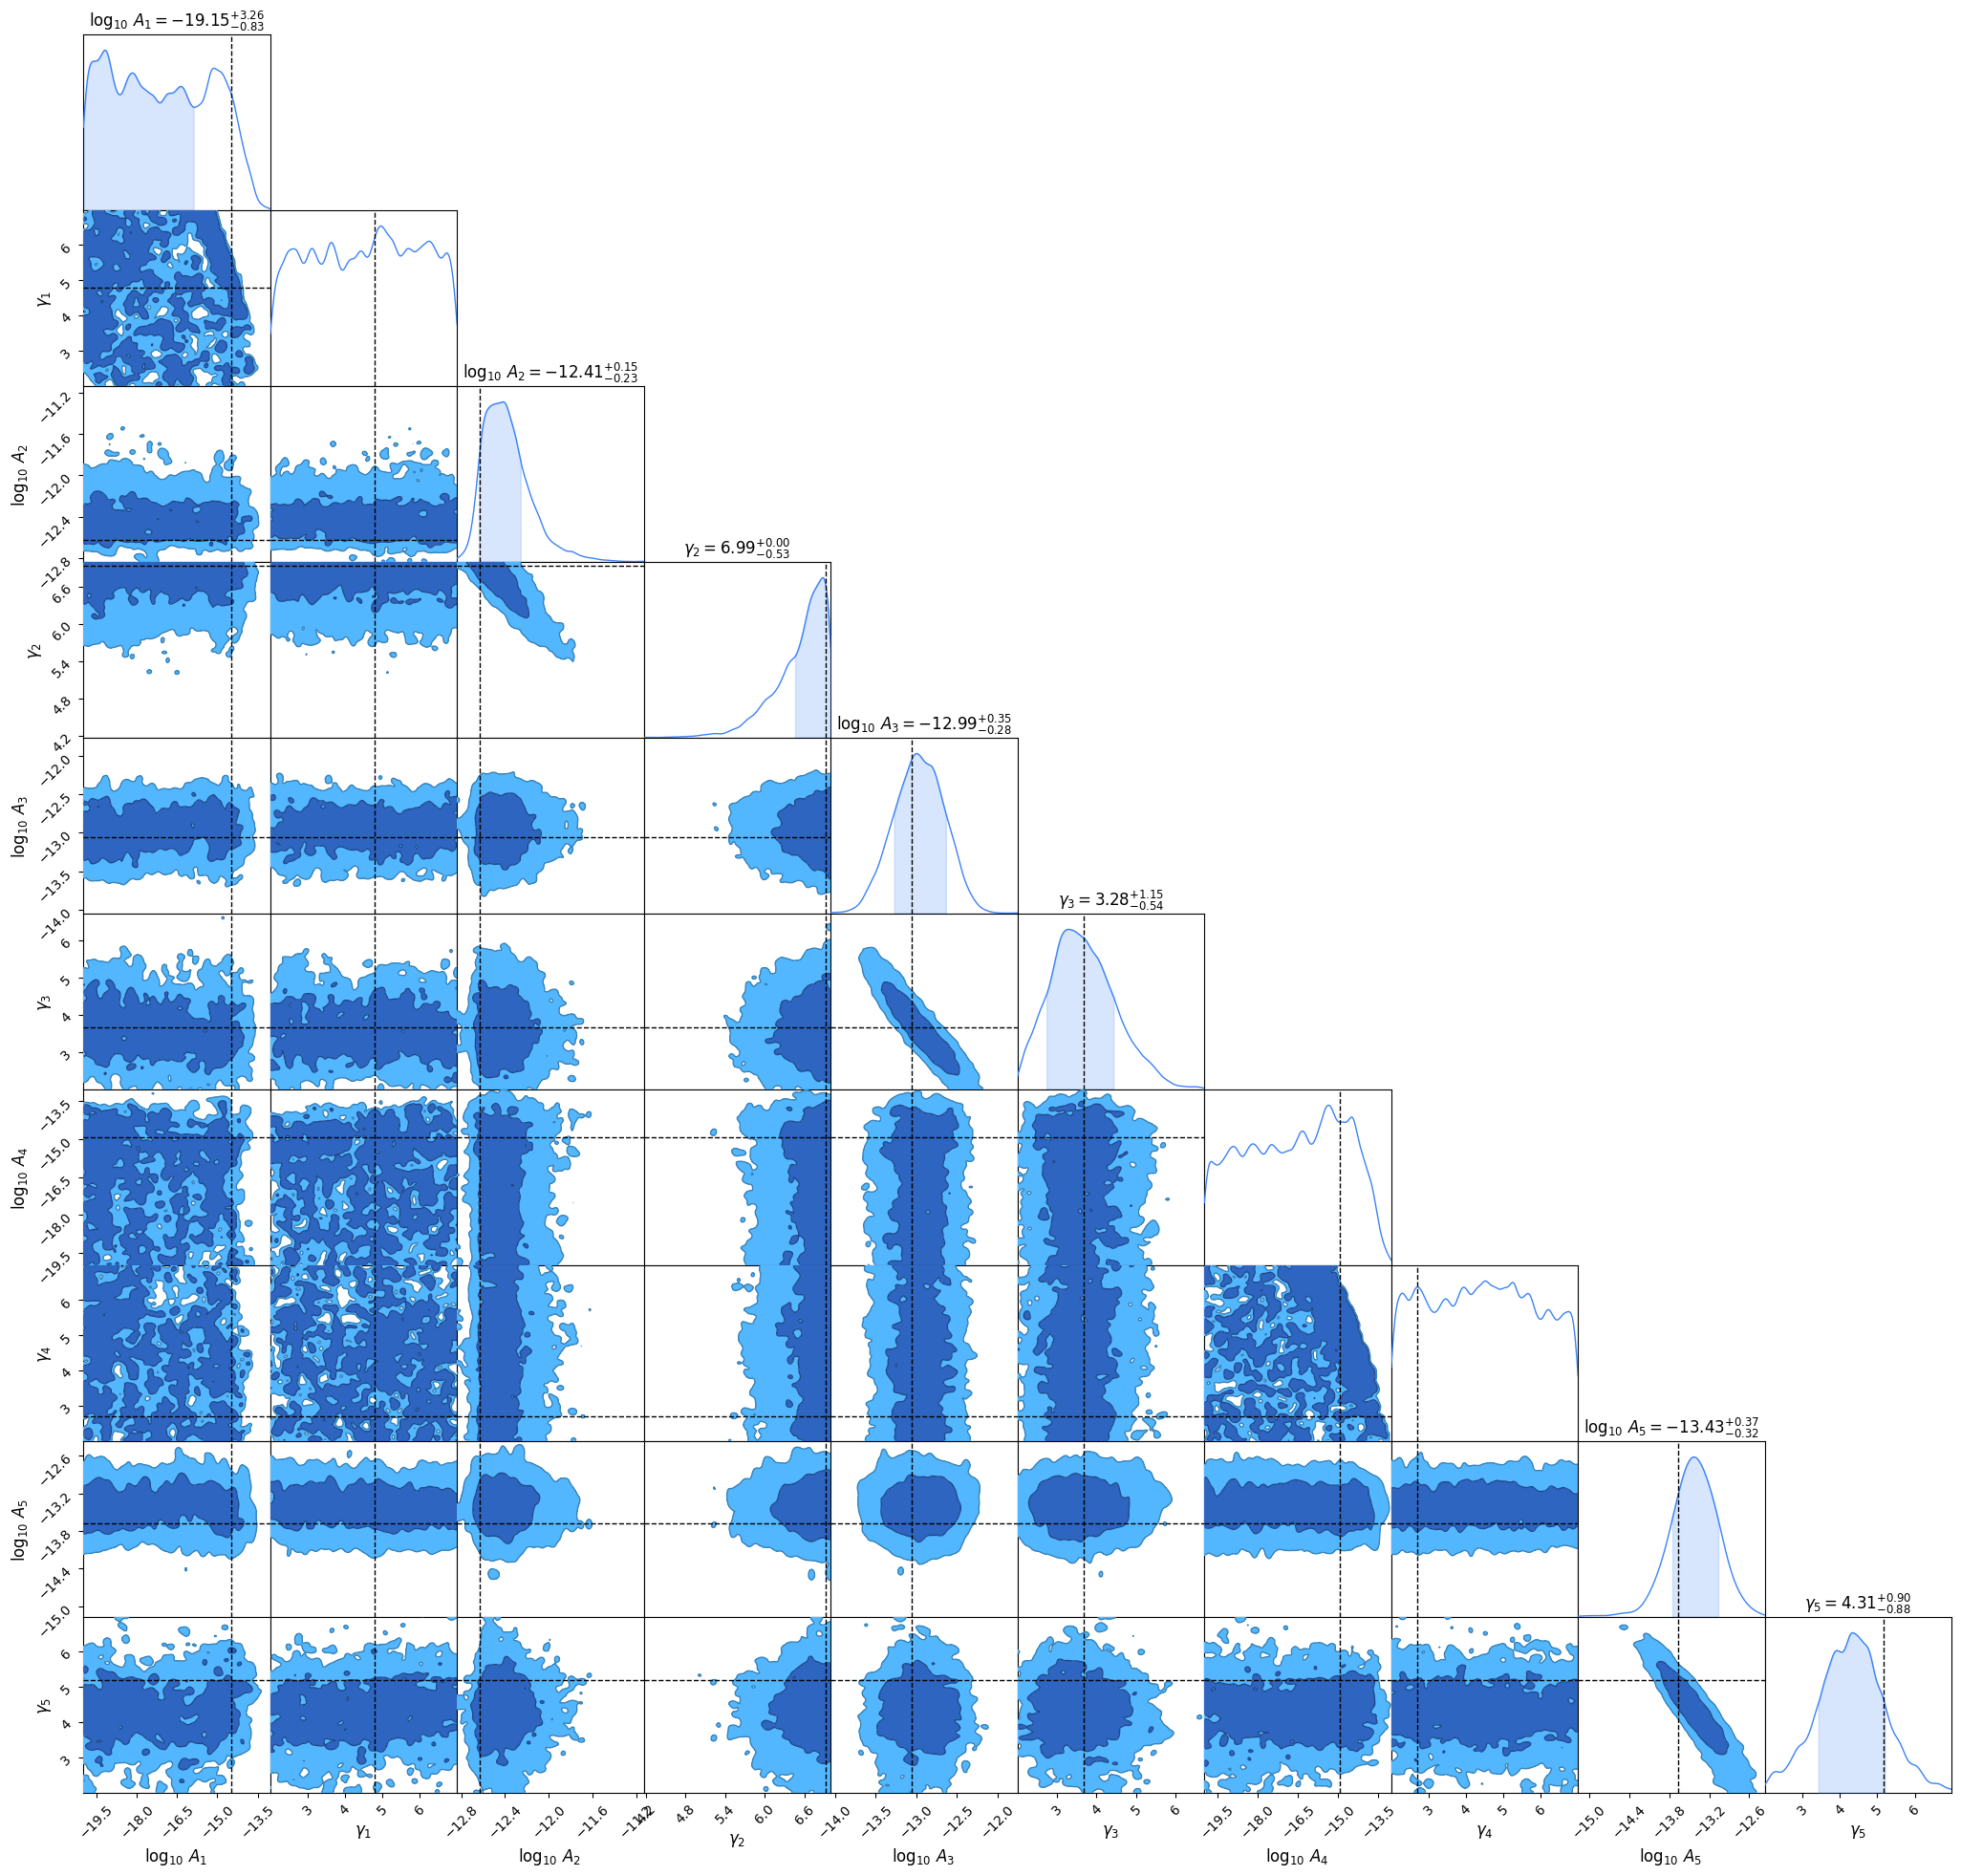

In [17]:
samples.corner_plt(pta.rn_ndxs)

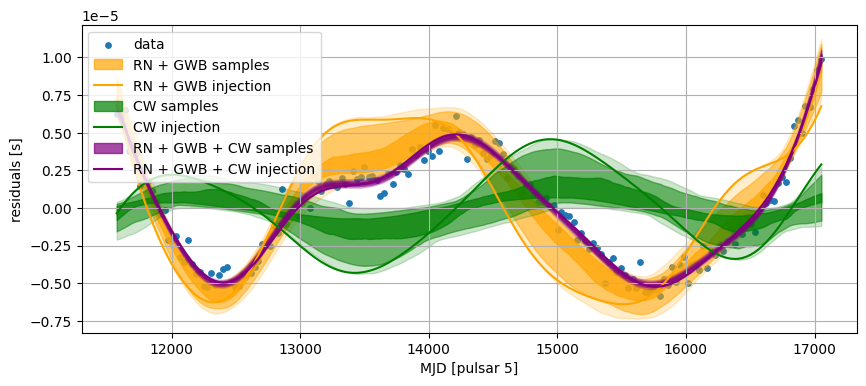

In [13]:
# Bayesogram
psr_ndx = 4
samples_arr = samples.samples
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (1000,))

# percentile layers for plotting densities of samples
percentile_layers = [2.5, 10., 30.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

# Bayesogram for RN + GWB
if pta.model_rn or pta.model_gwb:
    rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples_arr[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha, label='RN + GWB samples')
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='orange', label='RN + GWB injection')

# Bayesogram for CW
if pta.model_cw:
    a_cws = np.array([pta.get_CW_coefficients(samples_arr[ndx, pta.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
    cw_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ a_cw for a_cw in a_cws])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha, label='CW samples')
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ cw_residuals_inj, color='green', label='CW injection')

# Bayesogram for RN + GWB + CW
if pta.model_rn and pta.model_gwb and pta.model_cw:
    signals = cw_signals + rn_gwb_signals
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha, label='RN + GWB + CW samples')
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='purple', label='RN + GWB + CW injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()